In [1]:
%load_ext autoreload
%autoreload 2
import os

while not os.getcwd().endswith("naml_exams"):
    os.chdir("..")

# Exercise 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

Load the dataset contained in the file `faces.mat`

In [3]:
data = sio.loadmat('data/faces.mat')
X = data['X']
X.shape

(5000, 1024)

The dataset contains a collection of 5000 32 × 32 grayscale face images.

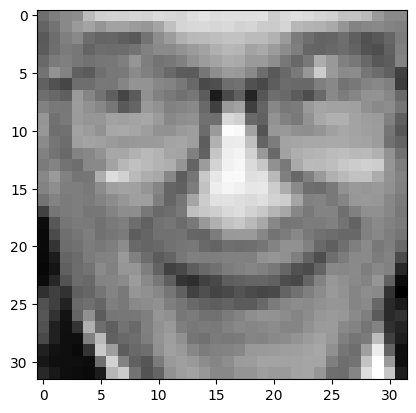

In [4]:
x0 = np.transpose(np.reshape(X[0,:],(32,32)))
plt.imshow(x0,cmap='gray')

Compute the normalized matrix $\hat{X}$

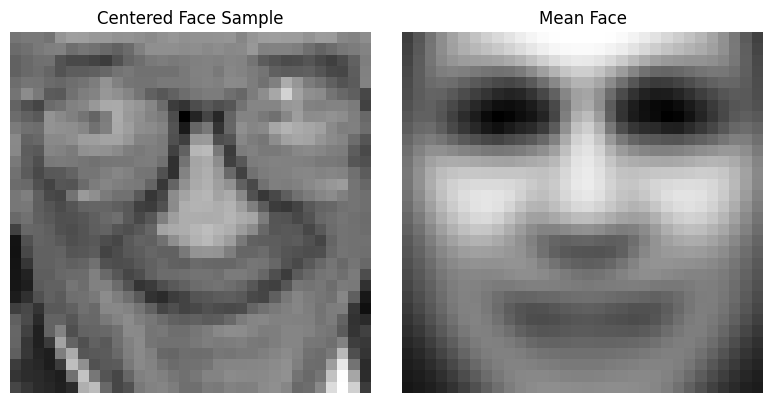

In [5]:
# Center the dataset
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean[None, :]

# Prepare the plots
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first centered face sample
first_centered_face = X_centered[0].reshape(32, 32).T
ax[0].imshow(first_centered_face, cmap='gray')
ax[0].set_title('Centered Face Sample')
ax[0].axis('off')

# Plot the mean face
mean_face = X_mean.reshape(32, 32).T
ax[1].imshow(mean_face, cmap='gray')
ax[1].set_title('Mean Face')
ax[1].axis('off')

plt.tight_layout()
plt.show()

Perform the PCA on $\hat{X}$ and plot the first 25 eigenfaces

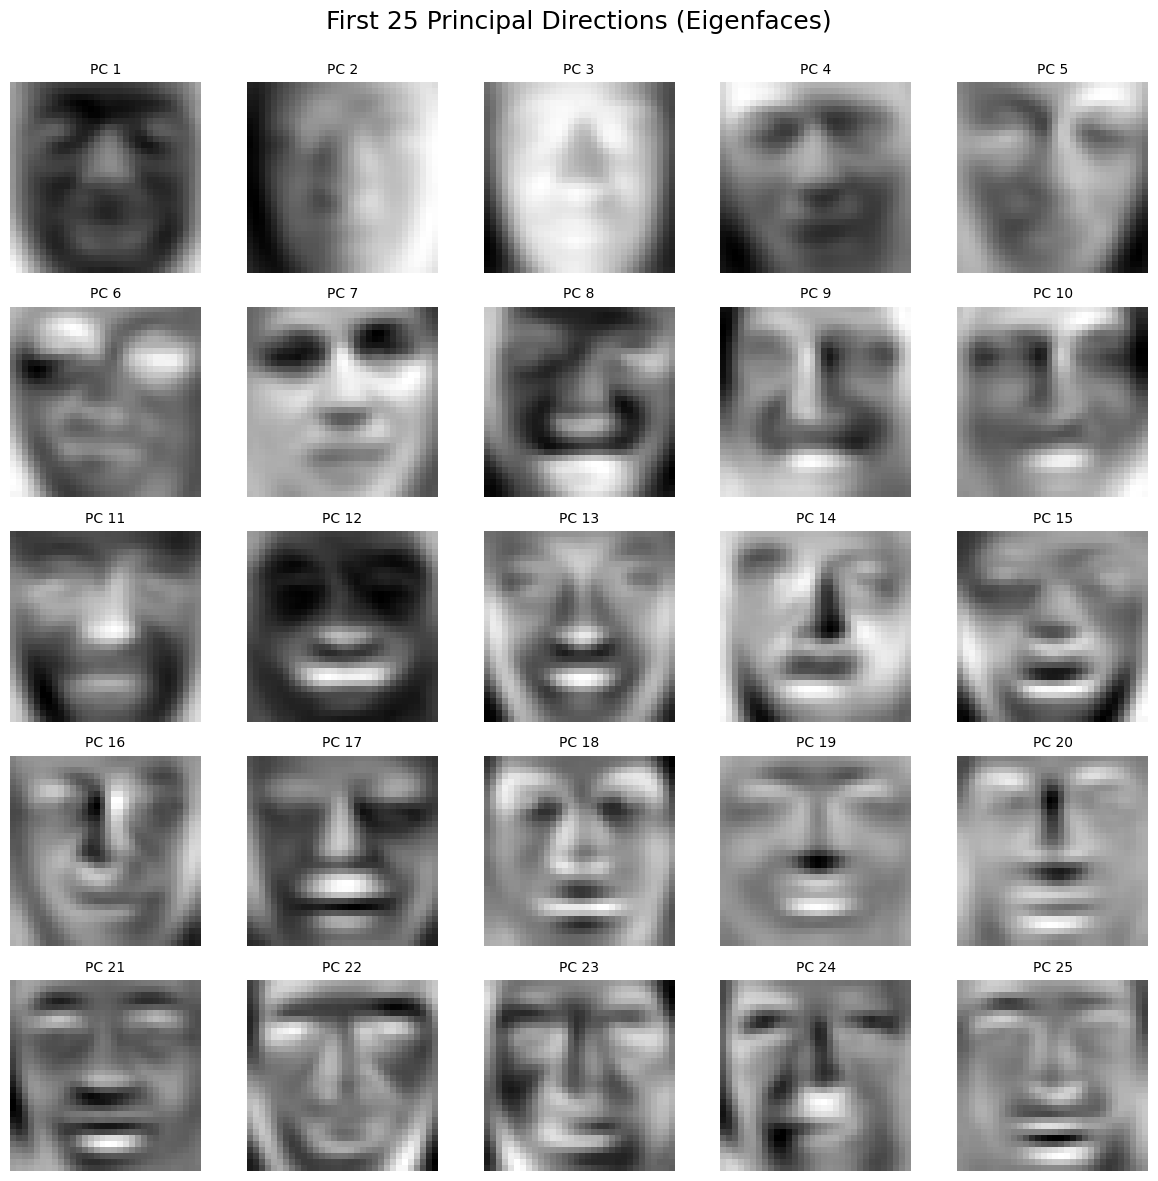

In [7]:
# Perform economy SVD on transposed centered data
X_pca = X_centered.T
U, s, Vt = np.linalg.svd(X_pca, full_matrices=False)

# Plot the first 25 principal directions (eigenfaces)
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
fig.suptitle('First 25 Principal Directions (Eigenfaces)', fontsize=18)

for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        eigenface = U[:, idx].reshape(32, 32).T
        ax[i, j].imshow(eigenface, cmap='gray')
        ax[i, j].set_title(f'PC {idx + 1}', fontsize=10)
        ax[i, j].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust space for suptitle
plt.show()

Reduce the dimension of the sample from 1024 (32 by 32) to 100 by projecting the matrix $\hat{X}$ onto $U$.

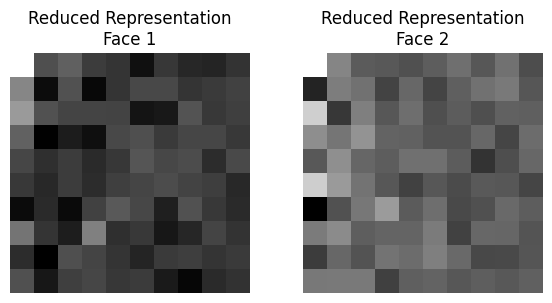

In [9]:
# Project centered data onto first 100 principal directions
X_reduced = X_centered @ U[:, :100]  # Shape: (num_samples, 100)

# Visualize reduced representations for first two faces
# Note: This is only a visualization trick and not meaningful spatially
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
for i in range(2):
    reduced = X_reduced[i].reshape(10, 10).T  # 100 = 10x10
    ax[i].imshow(reduced, cmap='gray')
    ax[i].set_title(f'Reduced Representation\nFace {i+1}')
    ax[i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

Plot the original images (pick the first 100 images) and the ones reconstructed from only the first 100 principal components. Plot also the error.

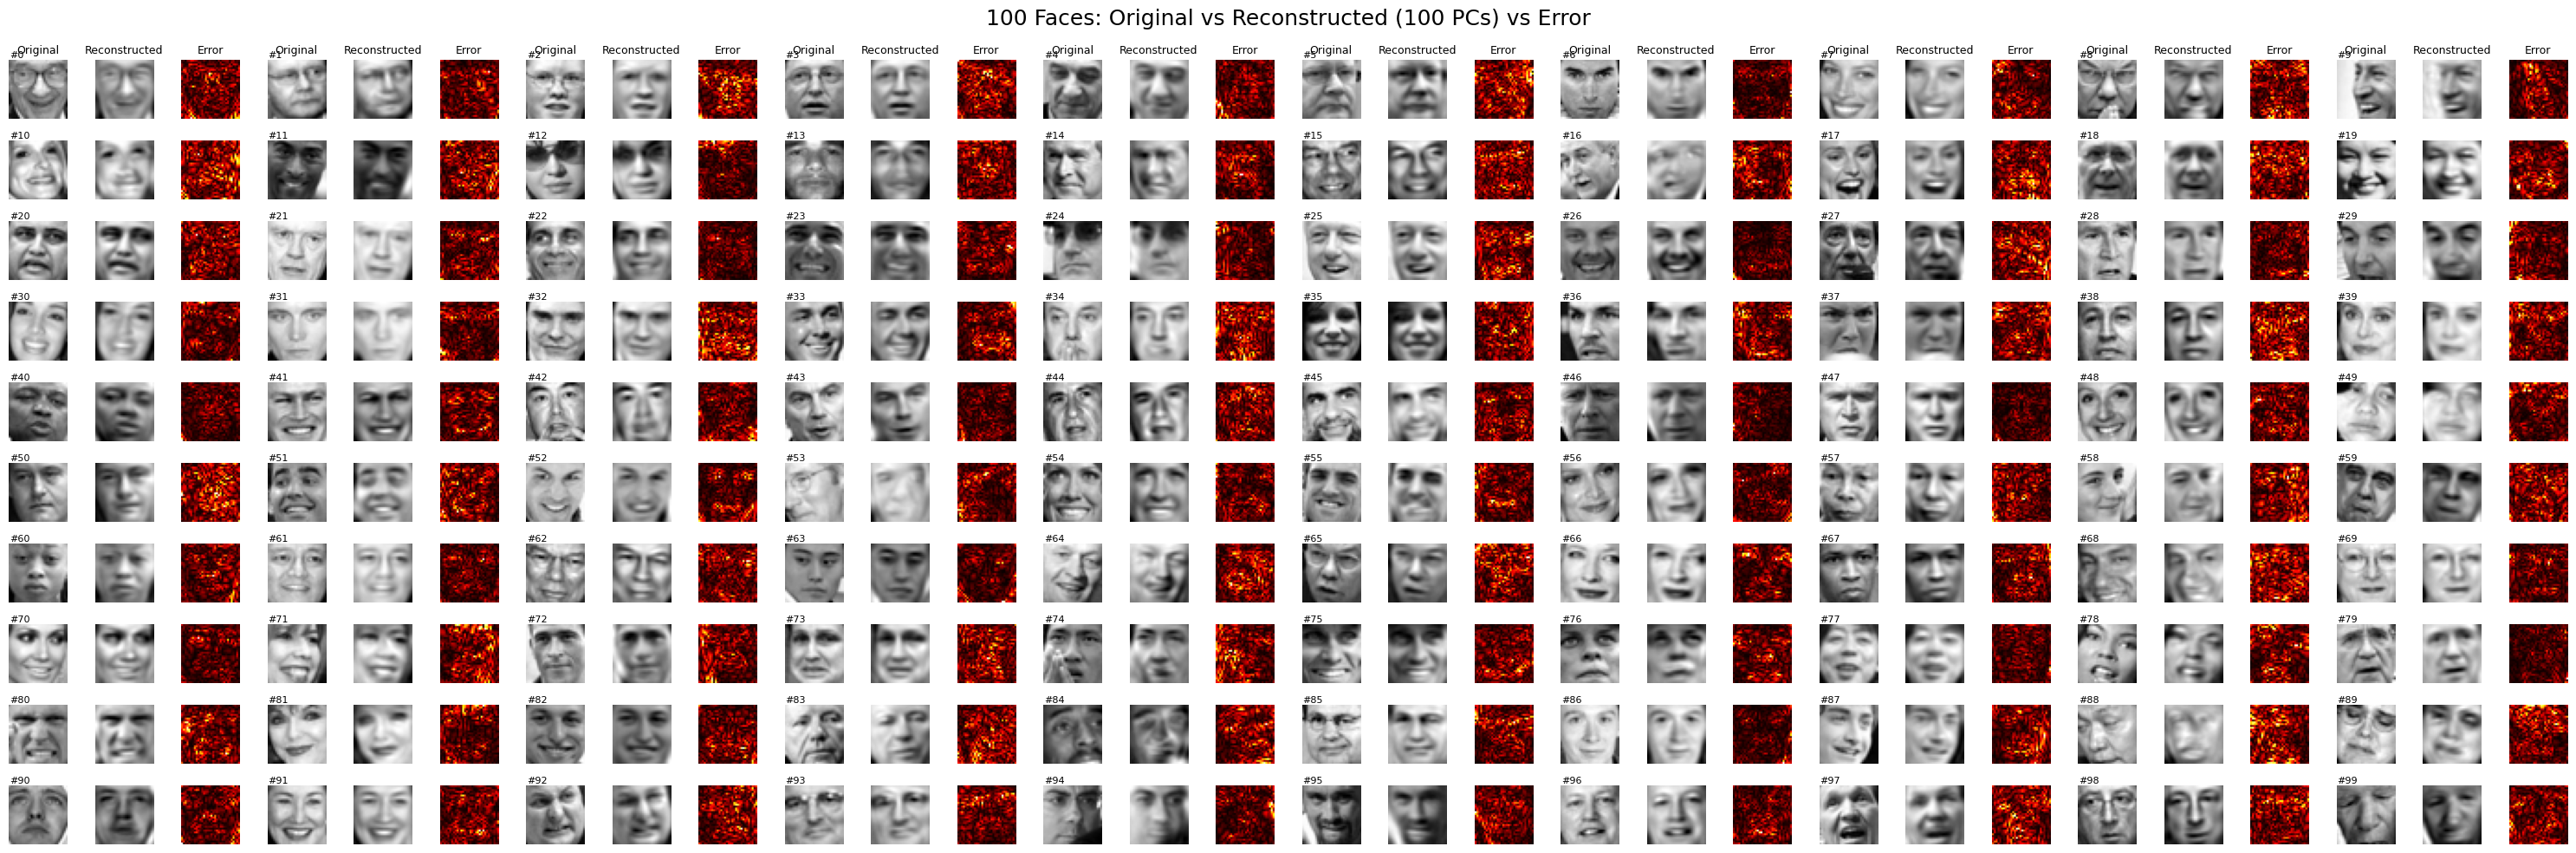

In [12]:
# Reduce dimension using first 100 principal components
X_reduced = X_centered @ U[:, :100]
X_reconstructed = X_reduced @ U[:, :100].T
X_reconstructed += X_mean[None, :]

# Compute reconstruction error
reconstruction_error = np.abs(X[:100] - X_reconstructed[:100])

# Set up plot
fig, axes = plt.subplots(10, 30, figsize=(30, 10))  # 10 rows, 30 columns

for i in range(100):
    row = i // 10
    col = (i % 10) * 3
    
    # Original image
    axes[row, col].imshow(X[i].reshape(32, 32).T, cmap='gray')
    axes[row, col].axis('off')
    if row == 0:
        axes[row, col].set_title('Original', fontsize=9)
    # Add image index above the original image
    axes[row, col].text(0, -2, f'#{i}', fontsize=8, color='black', ha='left')

    # Reconstructed image
    axes[row, col + 1].imshow(X_reconstructed[i].reshape(32, 32).T, cmap='gray')
    axes[row, col + 1].axis('off')
    if row == 0:
        axes[row, col + 1].set_title('Reconstructed', fontsize=9)

    # Error heatmap
    axes[row, col + 2].imshow(reconstruction_error[i].reshape(32, 32).T, cmap='hot')
    axes[row, col + 2].axis('off')
    if row == 0:
        axes[row, col + 2].set_title('Error', fontsize=9)

fig.suptitle('100 Faces: Original vs Reconstructed (100 PCs) vs Error', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


# Exercise 2

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

Consider the following simple linear network:
$$
a(\mathbf{v},\mathbf{w}) = \mathbf{w} \cdot \mathbf{v} \tag{1}, 
$$
where $\mathbf{w}=[w, b]^T$ is the parameter vector ($w$ is the weight and $b$ the bias) and $\mathbf{v} = [x, 1]^T$ is the input vector.

Consider the sample $(x_1,y_1) = (2, 0.5)$ and $(x_2, y_2) = (-1, 0)$ and the cost function 
$$
J(\mathbf{w})=(y_1 - a(\mathbf{v}_1, \mathbf{w}))^2 + (y_2 - a(\mathbf{v}_2, \mathbf{w}))^2 \tag{2}
$$
where $\mathbf{v}_1 = [x_1,1]^T$ and $\mathbf{v}_2 = [x_2,1]^T$.

In [13]:
def J_original(w, v1, v2, y1, y2):
	return (y1 - np.dot(w.T, v1))**2 + (y2 - np.dot(w.T, v2))**2

Rewrite equation (2) as $J(\mathbf{w}) = {{1}\over{2}} \mathbf{w}^T A \mathbf{w} + d^T \mathbf{w} + c$ (write explicitly A, d and c).

1. **Cost Function Definition**:
   The cost function is given as:
   $$
   J(\mathbf{w}) = (y_1 - a(\mathbf{v}_1, \mathbf{w}))^2 + (y_2 - a(\mathbf{v}_2, \mathbf{w}))^2,
   $$
   where $ a(\mathbf{v}, \mathbf{w}) = \mathbf{w} \cdot \mathbf{v} $. Substituting this, we get:
   $$
   J(\mathbf{w}) = (y_1 - \mathbf{w}^T \mathbf{v}_1)^2 + (y_2 - \mathbf{w}^T \mathbf{v}_2)^2.
   $$

2. **Expand the Squares**:
   Expanding each term:
   $$
   (y_i - \mathbf{w}^T \mathbf{v}_i)^2 = y_i^2 - 2y_i (\mathbf{w}^T \mathbf{v}_i) + (\mathbf{w}^T \mathbf{v}_i)^2.
   $$
   Applying this to both terms, we get:
   $$
   J(\mathbf{w}) = y_1^2 - 2y_1 (\mathbf{w}^T \mathbf{v}_1) + (\mathbf{w}^T \mathbf{v}_1)^2 + y_2^2 - 2y_2 (\mathbf{w}^T \mathbf{v}_2) + (\mathbf{w}^T \mathbf{v}_2)^2.
   $$

3. **Combine Terms**:
   Rearrange $ J(\mathbf{w}) $ as:
   $$
   J(\mathbf{w}) = \left[ (\mathbf{w}^T \mathbf{v}_1)^2 + (\mathbf{w}^T \mathbf{v}_2)^2 \right] 
   - 2 \left[ y_1 (\mathbf{w}^T \mathbf{v}_1) + y_2 (\mathbf{w}^T \mathbf{v}_2) \right] 
   + (y_1^2 + y_2^2).
   $$

4. **Matrix Representation**:
   Each term can be rewritten in matrix form:
   - The quadratic term $ (\mathbf{w}^T \mathbf{v}_i)^2 $ expands as $ \mathbf{w}^T (\mathbf{v}_i \mathbf{v}_i^T) \mathbf{w} $.
   - The linear term $ -2 y_i (\mathbf{w}^T \mathbf{v}_i) $ becomes $ -2 y_i \mathbf{v}_i^T \mathbf{w} $.
   - The constant $ y_1^2 + y_2^2 $ remains unchanged.

   Summing over both samples, we get:
   $$
   J(\mathbf{w}) = \mathbf{w}^T \left( \mathbf{v}_1 \mathbf{v}_1^T + \mathbf{v}_2 \mathbf{v}_2^T \right) \mathbf{w} 
   - 2 \mathbf{w}^T \left( y_1 \mathbf{v}_1 + y_2 \mathbf{v}_2 \right) + \left( y_1^2 + y_2^2 \right).
   $$

5. **Identify $\mathbf{A}$, $\mathbf{d}$, and $c$**:
   Comparing with the quadratic form, we identify:
   $$
   \mathbf{A} = 2 \left( \mathbf{v}_1 \mathbf{v}_1^T + \mathbf{v}_2 \mathbf{v}_2^T \right),
   $$
   $$
   \mathbf{d} = -2 \left( y_1 \mathbf{v}_1 + y_2 \mathbf{v}_2 \right),
   $$
   $$
   c = y_1^2 + y_2^2.
   $$


**In our case:**   
Substituting $\mathbf{v}_1 = [2, 1]^T$ and $\mathbf{v}_2 = [-1, 1]^T$:
   - $\mathbf{v}_1 \mathbf{v}_1^T = \begin{bmatrix} 4 & 2 \\ 2 & 1 \end{bmatrix}$,
   - $\mathbf{v}_2 \mathbf{v}_2^T = \begin{bmatrix} 1 & -1 \\ -1 & 1 \end{bmatrix}$,
   - $\mathbf{v}_1 \mathbf{v}_1^T + \mathbf{v}_2 \mathbf{v}_2^T = \begin{bmatrix} 5 & 1 \\ 1 & 2 \end{bmatrix}$,
   - $\mathbf{A} = 2 \begin{bmatrix} 5 & 1 \\ 1 & 2 \end{bmatrix} = \begin{bmatrix} 10 & 2 \\ 2 & 4 \end{bmatrix}$,
   - $\mathbf{d} = -2 \left( 0.5 \begin{bmatrix} 2 \\ 1 \end{bmatrix} + 0 \begin{bmatrix} -1 \\ 1 \end{bmatrix} \right) = -2 \begin{bmatrix} 1 \\ 0.5 \end{bmatrix} = \begin{bmatrix} -2 \\ -1 \end{bmatrix}$,
   - $c = 0.5^2 + 0^2 = 0.25$.

so:
$$
\mathbf{A} = \begin{bmatrix} 10 & 2 \\ 2 & 4 \end{bmatrix}, \quad \mathbf{d} = \begin{bmatrix} -2 \\ -1 \end{bmatrix}, \quad c = 0.25.
$$

In [12]:
def J(w, v1, v2, y1, y2):
	A = 2 * (np.outer(v1, v1) + np.outer(v2, v2))
	d = -2 * (y1 * v1 + y2 * v2)
	c = y1**2 + y2**2
	return 0.5 * np.dot(w.T, np.dot(A, w)) + np.dot(d.T, w) + c

In [13]:
w = np.random.randn(2)
v1 = np.array([2., 1.])
v2 = np.array([-1., 1.])
y1 = 0.5
y2 = 0.

print(f"J(w) = {J(w, v1, v2, y1, y2)}")
print(f"J_original(w) = {J_original(w, v1, v2, y1, y2)}")

J(w) = 2.5515009738505845
J_original(w) = 2.551500973850585


Compute the optimal parameter vector $\mathbf{w}^*$ that minimize $J(\mathbf{w})$


Given that the cost function as we have redefined it is a quadratic function we know that the derivative can be written as:

$$
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}} = \mathbf{A} \mathbf{w} + \mathbf{d}.
$$

And in our particular case we have:

$$
\mathbf{A} = \begin{bmatrix} 10 & 2 \\ 2 & 4 \end{bmatrix}, \quad \mathbf{d} = \begin{bmatrix} -2 \\ -1 \end{bmatrix}.
$$

So by setting the derivative to zero we can find the critical points:

$$
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}} = \mathbf{A} \mathbf{w} + \mathbf{d} = \begin{bmatrix} 0\\0 \end{bmatrix}
\\
\begin{bmatrix} 10 & 2 \\ 2 & 4 \end{bmatrix} \begin{bmatrix} w_1 \\ w_2 \end{bmatrix} + \begin{bmatrix} -2 \\ -1 \end{bmatrix} = \begin{bmatrix} 0\\0 \end{bmatrix}
$$
so we get the system:
$$
10w_1 + 2w_2 - 2 = 0 \ and \quad 2w_1 + 4w_2 - 1 = 0.

$$

Solving the system of equations we get:
$$
w_1 = \frac{1}{6}, \quad w_2 = \frac{1}{6}.
$$

Furthermore given that J is a quadratic function we know that all its critical points are global minima. So $w_1 = \frac{1}{6}, \quad w_2 = \frac{1}{6}$ is the optimal parameter vector that minimizes $J(\mathbf{w})$.

In [ ]:
def J_jax(w, v1, v2, y1, y2):
	A = 2 * (jnp.outer(v1, v1) + jnp.outer(v2, v2))
	d = -2 * (y1 * v1 + y2 * v2)
	c = y1**2 + y2**2
	return 0.5 * jnp.dot(w.T, jnp.dot(A, w)) + jnp.dot(d.T, w) + c

gradJ = jax.jit(jax.grad(J_jax, argnums=0))

w_star = jnp.array([1/6, 1/6])

print(f"J(w_star) = {J_jax(w_star, v1, v2, y1, y2)}")
print(f"gradJ(w_star) = {gradJ(w_star, v1, v2, y1, y2)}")

J(w_star) = 0.0
gradJ(w_star) = [2.9802322e-08 2.9802322e-08]


Plot the surface that represents J

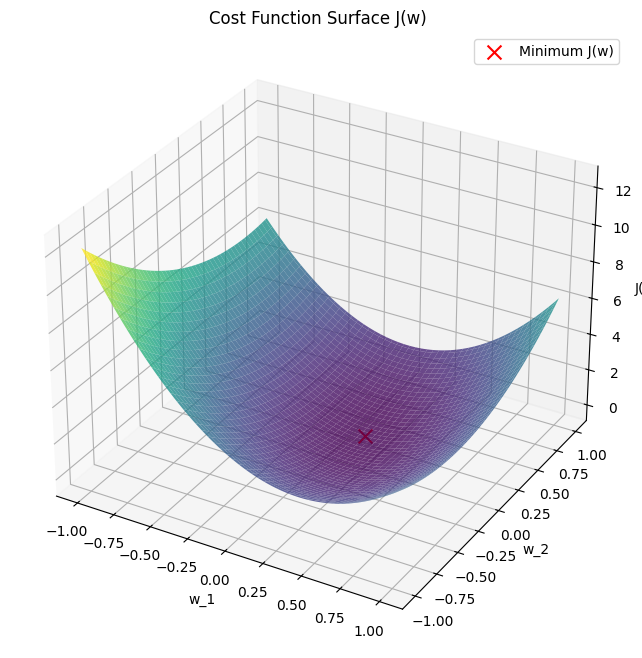

In [14]:
# Create a grid of values for w1 and w2
w1 = np.linspace(-1, 1, 100)
w2 = np.linspace(-1, 1, 100)
W1, W2 = np.meshgrid(w1, w2)

# Compute the cost function values for each point in the grid
J_values = np.array([[J(np.array([w1, w2]), v1, v2, y1, y2) for w1 in w1] for w2 in w2])

# Plot the cost surface in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, J_values, cmap='viridis', alpha=0.8)

# Add 1/6, 1/6, J(1/6, 1/6) to the plot as the minimum
ax.scatter(1/6, 1/6, J(np.array([1/6, 1/6]), v1, v2, y1, y2), color='r', s=100, label='Minimum J(w)', marker='x')
ax.legend()

ax.set_xlabel('w_1')
ax.set_ylabel('w_2')
ax.set_zlabel('J(w)')
ax.set_title('Cost Function Surface J(w)')
plt.show()

Implement the gradient descent method to compute $\mathbf{w}^*$, set the initial guess $\mathbf{w}^{(0)}$ equal to $[1, 1]^T$ and the learning rate $\eta$ equal to $0.05$ 

In [15]:
def GD(w, v1, v2, y1, y2, alpha, n_iter):
	for i in range(n_iter):
		w = w - alpha * gradJ(w, v1, v2, y1, y2)
	return w

w_init = np.array([1., 1.])
alpha = 0.05
n_iter = 1000

w_opt = GD(w_init, v1, v2, y1, y2, alpha, n_iter)

print(f"Optimal w = {w_opt}")
print(f"J(w_opt) = {J(w_opt, v1, v2, y1, y2)}") # Close to zero up to numerical precision

Optimal w = [0.16666666 0.1666667 ]
J(w_opt) = 2.220446049250313e-15


What is the maximum value of the learning rate that can be used?

Given that the loss function is a quadratic function with a positive definite Hessian matrix, we know that the loss function is convex. This means that the gradient descent algorithm will converge for any learning rate $\eta$ such that:

$$
0 < \eta < \frac{2}{\lambda_{\text{max}}}
$$

where $\lambda_{\text{max}}$ is the largest eigenvalue of the Hessian matrix. In our case the Hessian matrix is $\mathbf{A}$ we can compute its eigenvalues and find the maximum learning rate.
$$


In [16]:
# Define the matrix A
A = np.array([[10, 2], 
              [2, 4]])

# Calculate the eigenvalues
eigenvalues = np.linalg.eigvals(A)

# Print the eigenvalues
print("Eigenvalues of A:", eigenvalues)

# So ve can calculate the upper limit of the learning rate
eta_max = 2 / (np.max(eigenvalues))
print(f"eta_max = {eta_max}")

Eigenvalues of A: [10.60555128  3.39444872]
eta_max = 0.18858048469644506


# Exercise 3

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Consider a logistic regression
$$
\sigma (\Beta^T \mathbf{x}) = \sigma (\beta_0 + \beta_1 x_1 + \beta_2 x_2) \tag{3}
$$

where $\sigma(c) = \frac{1}{1 + \exp (-c)}$.

| Point ID | Set 1           |       |       | Set 2           |       |       | Set 3           |       |       |
|----------|-----------------|-------|-------|-----------------|-------|-------|-----------------|-------|-------|
|          | x₁              | x₂    | Label | x₁              | x₂    | Label | x₁              | x₂    | Label |
| 1        | 0               | 0     | 0     | 0               | 0     | 0     | 0               | 0     | 1     |
| 2        | 1               | 0     | 0     | 0               | 1     | 0     | 1               | 0     | 0     |
| 3        | 0               | -1    | 0     | -1              | 0     | 0     | 0               | 1     | 0     |
| 4        | -1              | 0     | 1     | 1               | 0     | 1     | -1              | 0     | 0     |
| 5        | 0               | 1     | 1     | 0               | -1    | 1     | 0               | -1    | 0     |


In [3]:
# Set 1: columns = [x1, x2, label]
set1 = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [0, -1, 0],
    [-1, 0, 1],
    [0, 1, 1],
])

# Set 2: columns = [x1, x2, label]
set2 = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [-1, 0, 0],
    [1, 0, 1],
    [0, -1, 1],
])

# Set 3: columns = [x1, x2, label]
set3 = np.array([
    [0, 0, 1],
    [1, 0, 0],
    [0, 1, 0],
    [-1, 0, 0],
    [0, -1, 0],
])

Plot in 3 pictures the data contained in the 3 datasets (use different colors or symbols for the two classes).

What is the main difference between set 1, set 2 and set 3 ?

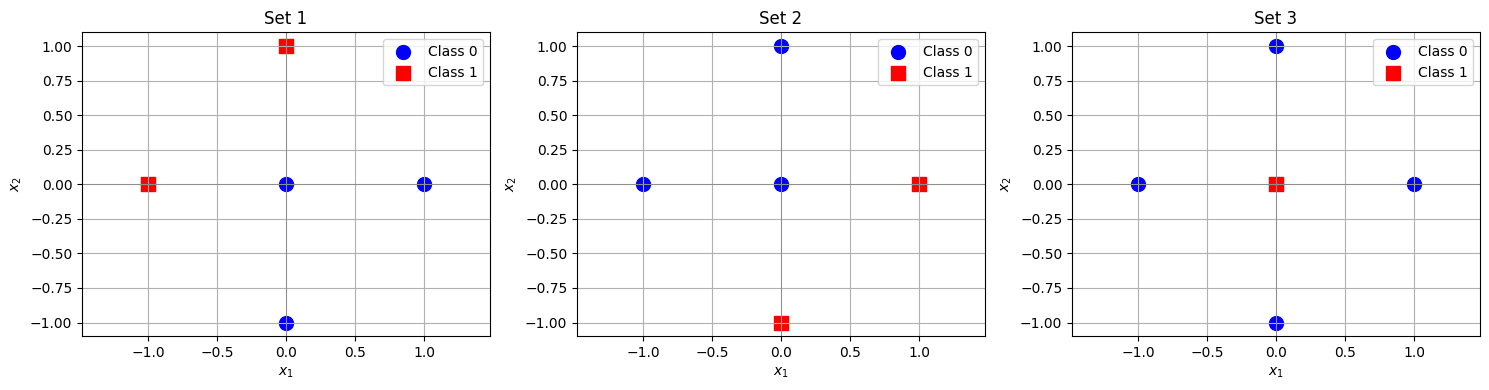

In [4]:
datasets = [set1, set2, set3]
titles = ["Set 1", "Set 2", "Set 3"]

plt.figure(figsize=(15, 4))

for i, data in enumerate(datasets, 1):
    plt.subplot(1, 3, i)
    for label, marker, color in zip([0,1], ['o', 's'], ['blue', 'red']):
        points = data[data[:, 2] == label]
        plt.scatter(points[:, 0], points[:, 1], label=f"Class {label}", marker=marker, color=color, s=100)
    plt.title(titles[i-1])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.grid(True)
    plt.legend()
    plt.axis('equal')

plt.tight_layout()
plt.show()

- Set 1: Classes are separated roughly along the x-axis; class 1 points lie on the left and top (negative x or positive y).

- Set 2: The class labels are flipped compared to Set 1 on some points; here class 1 points appear on the right side.

- Set 3: The labels are quite different — class 1 only appears at the origin point, while the rest are class 0, flipping the label distribution again.

In essence, each set changes the label assignments on the same or similar points, creating different class distributions and decision boundaries. This affects how easily a classifier could separate the classes.

Compute the vectors $\Beta$ that allow to use (3) to classify the data contained in set 1 and set 2 assuming a
threshold $\epsilon = 0.5$ for the positive class. Is the solution unique? Motivate your answer

In [8]:
def compute_beta(X, y, epsilon=0.5):
    # Add bias term (column of ones)
    X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
    
    # Transform labels to +1 (class 1) and -1 (class 0) for inequalities
    y_signed = 2 * y - 1
    
    # Construct matrix and vector for linear inequalities:
    # y_signed * (X_aug @ beta) >= 0
    # Here we want to find beta such that all constraints hold
    
    # This is a linear feasibility problem, often solved by linear programming or SVM.
    # For simplicity, solve using least squares with constraints ignored (approximation):
    beta, residuals, rank, s = np.linalg.lstsq(X_aug, y_signed, rcond=None)
    
    # Adjust bias term to incorporate epsilon:
    # Since bias = -epsilon, we shift it by adding epsilon:
    beta[0] = beta[0] - epsilon
    
    return beta

def plot_set_with_boundary(X, y, beta, title):
    plt.figure(figsize=(6,6))
    
    # Plot points by class
    for label, marker, color in zip([0,1], ['o', 's'], ['blue', 'red']):
        points = X[y == label]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color, s=100, label=f'Class {label}')
    
    # Plot decision boundary: β0 + β1 x1 + β2 x2 = 0
    # Solve for x2 = (-β0 - β1 x1) / β2
    x_vals = np.array([X[:,0].min() - 1, X[:,0].max() + 1])
    if abs(beta[2]) > 1e-6:
        y_vals = (-beta[0] - beta[1] * x_vals) / beta[2]
        plt.plot(x_vals, y_vals, 'k--', label='Decision boundary')
    else:
        # Vertical line if β2 ~ 0
        x_boundary = -beta[0]/beta[1]
        plt.axvline(x_boundary, color='k', linestyle='--', label='Decision boundary')
    
    plt.title(title)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

Beta for Set 1: [-0.7 -1.   1. ]
Beta for Set 2: [-0.7  1.  -1. ]


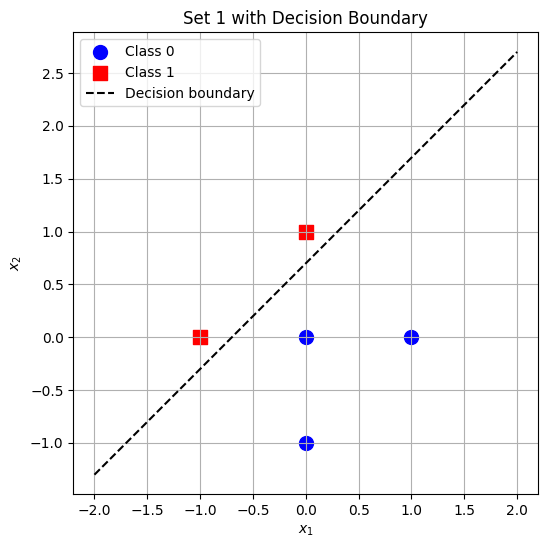

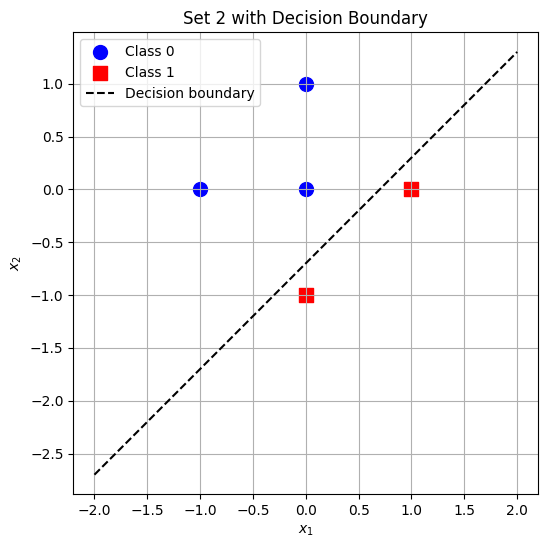

In [9]:
X1, y1 = set1[:, :2], set1[:, 2]
X2, y2 = set2[:, :2], set2[:, 2]

beta1 = compute_beta(X1, y1)
beta2 = compute_beta(X2, y2)

print("Beta for Set 1:", beta1)
print("Beta for Set 2:", beta2)
plot_set_with_boundary(X1, y1, beta1, "Set 1 with Decision Boundary")
plot_set_with_boundary(X2, y2, beta2, "Set 2 with Decision Boundary")

No, the solution is generally not unique.

Because the problem only constrains the sign of $\mathbf{\tilde{x}^T \tilde{\Beta}}$, any positive scaling of $\tilde{\Beta}$ yields the same classification boundary.

Moreover, if the data are linearly separable with margin, there are infinitely many $\tilde{\Beta}$ vectors that satisfy the inequalities, differing by scale or orientation.

Without additional constraints (like normalization or margin maximization in SVM), the linear classifier parameters are not unique.

Consider the following alternative system of coordinate $(\xi_1, \xi_2)$ to define the data contained in set 3

| Point ID | Set 1    |         |       | 
|----------|----------|---------|-------|
|          | $\xi_1$  | $\xi_2$ | Label |
| 1        | 0        | 0       | 1     |
| 2        | 0        | 0       | 0     | 
| 3        | 0        | 1       | 0     |
| 4        | 1        | 0       | 0     |
| 5        | 1        | 0       | 0     | 

Explain how we can use $\xi_1$ and $\xi_2$ to classify the data contained in set 3.

The ($\xi_2, \xi_2$) space partially separates the classes.

A simple rule-based classifier could work: classify as 1 if both $\xi_2, \xi_2$ are 0.

Propose a neural network to determine the parameters to be used to classify set 3.

We propose a small feedforward neural network with:

- Input: 2 features $(x_1, x_2)$

- Hidden layer: 1 layer with a few neurons (e.g., 8), using non-linear activation (e.g., ReLU or tanh)

- Output: 1 neuron with a sigmoid activation to output a probability for class 1.

In [13]:
# Set 3 data
X = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [0.0, 1.0],
    [-1.0, 0.0],
    [0.0, -1.0],
])

y = np.array([[1], [0], [0], [0], [0]])  # Column vector

# Hyperparameters
input_dim = 2
hidden_dim = 8
output_dim = 1
lr = 0.1
epochs = 1000

# Update architecture
hidden_dim = 8
epochs = 3000
lr = 0.1

# Reinitialize weights with better scaling
W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2 / input_dim)
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2 / hidden_dim)
b2 = np.zeros((1, output_dim))

# Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)

def tanh_derivative(a):
    return 1 - a**2

# Training loop
loss_history = []
for epoch in range(epochs):
    # Forward pass
    Z1 = X @ W1 + b1
    A1 = np.tanh(Z1)
    Z2 = A1 @ W2 + b2
    A2 = sigmoid(Z2)

    # Loss (binary cross-entropy)
    epsilon = 1e-8  # to prevent log(0)
    loss = -np.mean(y * np.log(A2 + epsilon) + (1 - y) * np.log(1 - A2 + epsilon))
    loss_history.append(loss)

    # Backward pass
    dZ2 = A2 - y
    dW2 = A1.T @ dZ2 / len(X)
    db2 = np.mean(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * tanh_derivative(A1)
    dW1 = X.T @ dZ1 / len(X)
    db1 = np.mean(dZ1, axis=0, keepdims=True)

    # Gradient descent update
    W2 -= lr * dW2
    b2 -= lr * db2
    W1 -= lr * dW1
    b1 -= lr * db1

# Final predictions
A2_final = sigmoid(np.tanh(X @ W1 + b1) @ W2 + b2)
predictions = (A2_final > 0.5).astype(int)

print("Final predictions:", predictions.ravel())
print("True labels:", y.ravel())

Final predictions: [1 0 0 0 0]
True labels: [1 0 0 0 0]
